In [48]:
import numpy as np
import pandas as pd

def preprocess_df(df: pd.DataFrame) -> pd.DataFrame:
    df = df[(df != "******").all(axis=1)]
    
    col_map = {
        "długośćmm": "dlugoscmm",
        "szerokośćmm": "szerokoscmm",
        "kąt": "kat",
        "obwódmm": "obwodmm",
        "średnica_fereta_hmm": "srednica_fereta_hmm",
        "średn._martinamm": "sredn._martinamm",
        "średn._sitowamm": "sredn._sitowamm",
        "średnia_jaskrawość": "srednia_jaskrawosc"
    }

    if "długośćmm" in df.columns:
        df = df.rename(columns=col_map)
        if "szerokoscmm" in df.columns:
            df["szerokoscmm"] = df["szerokoscmm"].astype(np.float64)

    return df


In [49]:
import pandas as pd
import cv2
import numpy as np

def process_one_image(CSV_PATH_CORRECT = 'KolejnyTest/5M/x/report_5_x.csv',CSV_PATH_PREDICTED = 'KolejnyTest/5M/x/report_5_x.csv',IMAGE_PATH = f'KolejnyTest/5M/x/a.jpg'   ,OUTPUT_PATH = f'KolejnyTest/5M/x/a_marked.jpg'):
    # === CONFIG ===
            # Path to the original image
        # Where to save the output image

    # === LOAD IMAGE AND DATA ===
    img = cv2.imread(IMAGE_PATH)
    df_real = preprocess_df(pd.read_csv(CSV_PATH_CORRECT))
    df_predicted = preprocess_df(pd.read_csv(CSV_PATH_PREDICTED))

    height, width = img.shape[:2]

    # === DRAW OBJECTS ===
    for i, row in df_real.iterrows():
        try:
            # Extract pixel coordinates
            x = int(row['xpix.'])
            y = int(row['ypix.'])
            
            # Extract size in mm → convert to pixels if needed (assuming 1mm = 10px for now, adjust as needed)
            width_mm = float(row['szerokoscmm'])
            height_mm = float(row['dlugoscmm'])
            angle = 90-float(row['kat'])  # OpenCV uses negative angle for rotation
            # angle = float(row['kat'])  # OpenCV uses negative angle for rotation

            mm_to_px = 10  # ⬅️ Adjust this scaling factor based on your image resolution

            width_px = int(width_mm * mm_to_px)
            height_px = int(height_mm * mm_to_px)

            # Draw ellipse representing the object
            center = (x, height-y)
            # axes = (1, 1)
            axes = (width_px // 2, height_px // 2)
            color = (0, 255, 0)  # Green
            thickness = 1

            cv2.ellipse(img, center, axes, angle, 0, 360, color, thickness)

            # Optional: draw ID
            cv2.putText(img, str(int(row['nr.'])), (x + 5, height - y - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 1)
        except Exception as e:
            print(e)

    
    for i, row in df_predicted.iterrows():
        try:
            # Extract pixel coordinates
            x = int(row['xpix.'])
            y = int(row['ypix.'])
            
            # Extract size in mm → convert to pixels if needed (assuming 1mm = 10px for now, adjust as needed)
            width_mm = float(row['szerokoscmm'])
            height_mm = float(row['dlugoscmm'])
            # angle = 90-float(row['kat'])  # OpenCV uses negative angle for rotation
            angle = float(row['kat'])  # OpenCV uses negative angle for rotation

            mm_to_px = 10  # ⬅️ Adjust this scaling factor based on your image resolution

            width_px = int(width_mm * mm_to_px)
            height_px = int(height_mm * mm_to_px)

            # Draw ellipse representing the object
            center = (x, height-y)
            # axes = (1, 1)
            axes = (width_px // 2, height_px // 2)
            color = (0, 0, 255)  # Red
            thickness = 1

            cv2.ellipse(img, center, axes, angle, 0, 360, color, thickness)

            # Optional: draw ID
            # cv2.putText(img, str(int(row['nr.'])), (x + 5, height - y - 5),
            #             cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0), 1)
        except Exception as e:
            print(e)

    # === SAVE RESULT ===
    cv2.imwrite(OUTPUT_PATH, img)
    print(f"Image saved to {OUTPUT_PATH}")

In [50]:
import os
import pandas as pd

def load_dfs_from_path(path="example"):

    combined_df = []

    for entry in os.scandir(path):  
        if entry.is_file() and entry.name.endswith(".csv"):
            df = pd.read_csv(entry.path)
            df = preprocess_df(df)
            combined_df.append(df)

    combined_df = pd.concat(combined_df, ignore_index=True)

    return combined_df

In [95]:
1.49*1.49

2.2201

In [51]:
def get_individual_stats(df,is_pred=False):
    df = preprocess_df(df)
    # Scaling
    df['dlugoscmm'] = df['dlugoscmm']/1.49
    df['szerokoscmm'] = df['szerokoscmm']/1.49
    df['powierzchniamm'] = df['powierzchniamm']/2.235

    # filtering the things that with high probability are not bacteria !TODO odkomentuj to po testach
    # df = df[df['dlugoscmm'] >= 0.2]
    # df = df[df['szerokoscmm'] <= 1.5]

    df['Pw'] = 3.14*(df['szerokoscmm']/2)**2+df['szerokoscmm']*(df['dlugoscmm']-df['szerokoscmm'])
    df['R'] = df['Pw'] / df['powierzchniamm']
    df['Dk'] = df['dlugoscmm']
    df['Sk'] = df['szerokoscmm']
    df['D/S'] = (df['Dk'] / df['Sk']).astype('float64')

    bacteria_types = []
    Dks = []
    Sks = []
    for idx,row  in df.iterrows():
        # if is_pred:
        #     row["R"] -= 0.5 
        #     row['D/S'] += 0.2
        if row['dlugoscmm'] < 0.2 or row['szerokoscmm'] > 1.5:
            Dks.append(row['dlugoscmm'])
            Sks.append(row['szerokoscmm'])
            bacteria_types.append("Removed_dim")
        elif row['R'] > 1.2:
            Dks.append(row['szerokoscmm'])
            Sks.append(row['Pw']*0.8)
            bacteria_types.append("Krzywe")
        else:
            Dks.append(row['dlugoscmm'])
            Sks.append(row['szerokoscmm'])
            if round(row['D/S'],15) > 1.5:
                bacteria_types.append("Pałeczki")
            else:
                bacteria_types.append("Ziarniaki")
    df['bacteria_type'] = bacteria_types
    df['Dk'] = Dks
    df['Sk'] = Sks

    df['Ob'] =(3.14*(df['Sk']**3)/6)+(3.14*((df['Sk']**2)/4)*(df['Dk']-df['Sk']))
    # !TODO remove this
    # df = df[df['Ob']>0]
    df.loc[df['Ob'] <= 0, 'bacteria_type'] = "removed_ob"
    # df['Ob'] = np.abs(df['Ob'])
    # -----------------

    df['bialko'] = 104.5 * (df['Ob']**0.59)
    df['wegiel'] = 0.86 * df['bialko']

    return df

In [52]:
def get_stats_for_bacteria_types(df,probe_volume_ml = 6):
    grouped = df.groupby("bacteria_type")
    result_count = grouped.size().reset_index(name="count")
    result = grouped["Ob"].mean().reset_index()

    result['bialko'] = 104.5 * (result['Ob']**0.59)
    result['wegiel'] = 0.86 * result['bialko']
    result['count_in_1_ml']=((result_count['count']*48097.39)/10)/(probe_volume_ml)
    result['biomasa'] =(((104.5*result['Ob']**0.59)*0.86)*result['count_in_1_ml'])/1000000

    return result

In [53]:
import numpy as np

def get_stats_for_for_ob_bins(df,probe_volume_ml = 6):
    bins = [0, 0.1, 0.2, 0.5, 1.0, float("inf")]
    labels = ["<=0.1", "0.1–0.2", "0.2–0.5", "0.5–1.0", ">1.0"]

    df["Ob_bucket"] = pd.cut(df["Ob"], bins=bins, labels=labels, right=True)

    grouped = df.groupby(["bacteria_type", "Ob_bucket"], observed=True)
    result_bio_stats = grouped.size().reset_index(name="count")

    total_bacteria_count = np.sum(result_bio_stats['count'])
    total_bacteria_count_1_ml = ((np.sum(result_bio_stats['count'])*48097.39)/10)/(probe_volume_ml)

    result_bio_stats['count_in_1_ml']=((result_bio_stats['count']*48097.39)/10)/(probe_volume_ml)
    result_bio_stats['bio_diversity'] =((result_bio_stats['count_in_1_ml']+1)/total_bacteria_count_1_ml)*np.log10((result_bio_stats['count_in_1_ml']+1)/total_bacteria_count_1_ml)

    return result_bio_stats

In [54]:
def get_speified_baceria_types_count(df):
    return df.groupby("bacteria_type").size().reset_index(name="count")

In [55]:
def get_shannon_index(result_bio_stats):
    return np.sum(result_bio_stats['bio_diversity'])*-1

In [56]:
import pandas as pd

def full_analyse(df,proube_volume_ml=6,is_pred = False):
    df = preprocess_df(df)
    df = get_individual_stats(df,is_pred=is_pred)
    result = get_stats_for_bacteria_types(df,probe_volume_ml=proube_volume_ml)
    result_bio_stats = get_stats_for_for_ob_bins(df,probe_volume_ml=proube_volume_ml)
    specified_types_count_predicted =  get_speified_baceria_types_count(df)
    shannon_index = np.sum(result_bio_stats['bio_diversity'])*-1
    print(f"Shannon index: {shannon_index}")

    return specified_types_count_predicted,df

In [57]:
def compare_results(df_real, df_predicted,proube_volume_ml=6):
    print("real:")
    real_classif,real_df = full_analyse(df_real,proube_volume_ml=proube_volume_ml)
    print("predicted:")
    predicted_classif,predicted_df = full_analyse(df_predicted,proube_volume_ml=proube_volume_ml,is_pred=True)
    real_classif = real_classif.add_suffix("_real")
    predicted_classif = predicted_classif.add_suffix("_predicted")
    merged = pd.merge(real_classif,predicted_classif,left_on="bacteria_type_real",right_on="bacteria_type_predicted", how="inner")
    merged = merged.drop(axis=1,columns=['bacteria_type_predicted'])
    merged = merged.rename(columns={"bacteria_type_real":"bacteria_type"})
    merged['error'] = merged['count_predicted']- merged['count_real']
    merged['relative_error'] = merged['error']/merged['count_real']
    return merged,real_df,predicted_df

In [58]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def conf_matrix(real_df,predicted_df):
    y_true = real_df['bacteria_type']
    y_pred = predicted_df['bacteria_type']

    cm = confusion_matrix(y_true, y_pred, labels=y_true.unique())
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_true.unique())
    disp.plot(cmap="Blues", xticks_rotation=45)


In [59]:
df = load_dfs_from_path("agata_1_y_no_model")
predicted_classif = full_analyse(df,proube_volume_ml=6)
print(predicted_classif)

Shannon index: 0.9252722551885972
(  bacteria_type  count
0        Krzywe     43
1      Pałeczki    112
2   Removed_dim      1
3     Ziarniaki     37,      nr.   xpix.  ypix.    xmm   ymm  powierzchniamm  dlugoscmm  szerokoscmm  \
0      1   950.5  937.5   95.1  93.8        0.487696   1.275168     0.201342   
1      2  1116.5  910.5  111.7  91.1        0.299776   0.805369     0.335570   
2      3   760.5  845.5   76.0  84.6        0.241611   0.671141     0.402685   
3      4   445.5  830.5   44.6  83.1        0.152125   0.536913     0.536913   
4      5  1068.5  789.5  106.9  79.0        0.407159   1.073826     0.469799   
..   ...     ...    ...    ...   ...             ...        ...          ...   
188   11   303.5  334.5   30.4  33.5        0.675615   1.275168     0.536913   
189   12   188.5  327.5   18.9  32.8        0.214765   0.604027     0.536913   
190   13   276.5  325.5   27.7  32.6        0.384787   0.939597     0.536913   
191   14   640.5  266.5   64.0  26.7        0.178

In [60]:
df = load_dfs_from_path("agata_1_y_real")
real_classif = full_analyse(df,proube_volume_ml=6)
print(real_classif)

Shannon index: 0.9239331094496491
(  bacteria_type  count
0        Krzywe     14
1      Pałeczki    204
2   Removed_dim      2
3     Ziarniaki    129
4    removed_ob      2,      nr.  xpix.  ypix.    xmm   ymm  powierzchniamm  dlugoscmm  szerokoscmm  \
0      1    529    914   52.9  91.4        0.519016   0.997723     0.553437   
1      2   1096    910  109.6  91.0        0.420582   1.148808     0.402685   
2      3   1253    851  125.3  85.1        0.322148   0.830155     0.408239   
3      4   1150    811  115.0  81.1        0.326622   0.785550     0.408239   
4      5   1177    781  117.7  78.1        0.612975   1.332177     0.474568   
..   ...    ...    ...    ...   ...             ...        ...          ...   
346   15    108    467   10.8  46.7        0.715884   1.189265     0.750358   
347   16     21    398    2.1  39.8        0.675615   0.960928     0.816478   
348   17    635    394   63.5  39.4        0.532438   1.383592     0.488598   
349   18    888    115   88.8  11.5 

In [61]:
df_real = load_dfs_from_path("agata_1_y_real_correct_index")
df_predicted = load_dfs_from_path("no_model_agata_4")
# df_predicted = load_dfs_from_path("agata_1_y_no_model_2")
# df_predicted['powierzchniamm'] *= 1.2
# df_predicted['dlugoscmm'] *= 1.1
# df_predicted['szerokoscmm'] *= 0.9

# df_predicted['szerokoscmm'] = df_real['szerokoscmm']
# df_predicted['dlugoscmm'] = df_real['dlugoscmm']
# df_predicted['powierzchniamm'] = df_real['powierzchniamm']
compared,real_df,predicted_df = compare_results(df_real=df_real,df_predicted=df_predicted,proube_volume_ml=6)
print(compared)

real:
Shannon index: 0.962345443927831
predicted:
Shannon index: 1.0102566888629567
  bacteria_type  count_real  count_predicted  error  relative_error
0        Krzywe          10               36     26        2.600000
1      Pałeczki         124               41    -83       -0.669355
2   Removed_dim           2               32     30       15.000000
3     Ziarniaki          56               40    -16       -0.285714
4    removed_ob           1               44     43       43.000000


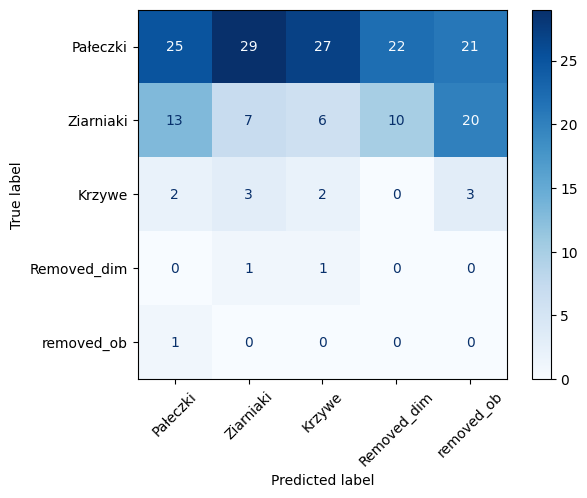

In [62]:
conf_matrix(real_df=real_df,predicted_df=predicted_df)

In [63]:
real_df[real_df['bacteria_type']=='removed_ob']

,nr.,xpix.,ypix.,xmm,ymm,powierzchniamm,dlugoscmm,szerokoscmm,kat,obwodmm,...,Pw,R,Dk,Sk,D/S,bacteria_type,Ob,bialko,wegiel,Ob_bucket
155,12,588,188,58.8,18.8,3.610738,6.06891,0.808161,169.81,20.544173,...,4.764233,1.319462,0.808161,3.811387,7.509534,removed_ob,-5.271825,NaN,NaN,NaN


<Axes: >

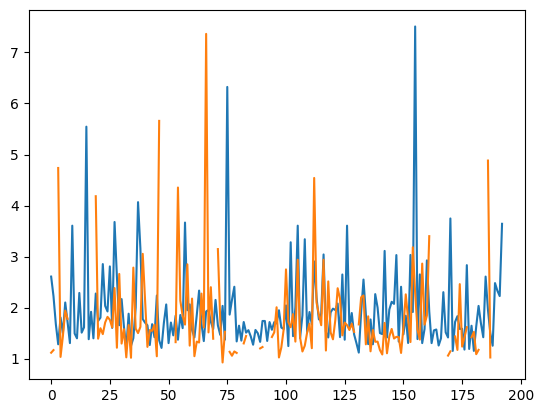

In [64]:
real_df['D/S'].plot()
predicted_df['D/S'].plot()

<Axes: >

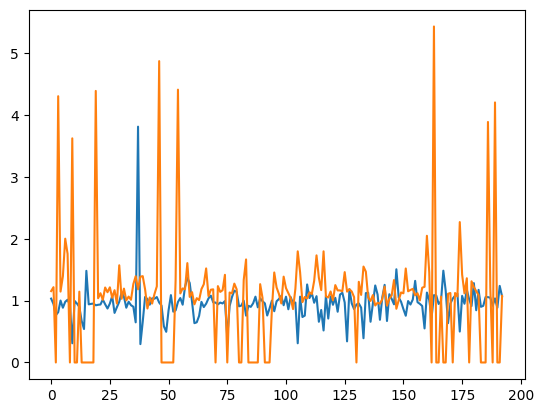

In [65]:
real_df['R'].plot()
predicted_df['R'].plot()

<Axes: >

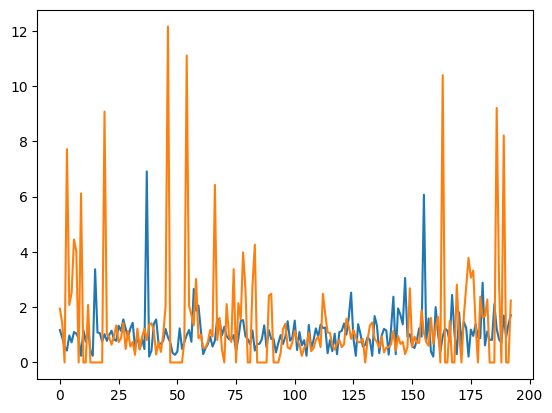

In [66]:
real_df['dlugoscmm'].plot()
predicted_df['dlugoscmm'].plot()

In [67]:
df_errors = pd.DataFrame()
df_errors['error_dlugoscmm'] = real_df['dlugoscmm']-predicted_df['dlugoscmm']
df_errors['error_szerokoscmm'] = real_df['szerokoscmm']-predicted_df['szerokoscmm']
df_errors['error_powierzchniamm'] = real_df['powierzchniamm']-predicted_df['powierzchniamm']
df_errors['error_R'] = real_df['R']-predicted_df['R']
df_errors['error_D/S'] = real_df['D/S']-predicted_df['D/S']
df_errors.corr()

,error_dlugoscmm,error_szerokoscmm,error_powierzchniamm,error_R,error_D/S
error_dlugoscmm,1.000000,0.706475,0.290247,0.857370,0.714904
error_szerokoscmm,0.706475,1.000000,0.290312,0.595749,0.117033
error_powierzchniamm,0.290247,0.290312,1.000000,-0.103449,0.303142
error_R,0.857370,0.595749,-0.103449,1.000000,0.612383
error_D/S,0.714904,0.117033,0.303142,0.612383,1.000000


In [68]:
df_real = pd.read_csv("agata_1_y_real_correct_index/raport_a8.csv")
df_predicted = pd.read_csv("no_model_agata_4/a8_raport_no_model.csv")


In [69]:
df_real

,nr.,xpix.,ypix.,xmm,ymm,powierzchniamm,długośćmm,szerokośćmm,kąt,obwódmm,...,średn._martinamm,średn._sitowamm,średnia_jaskrawość,r,g,b,y,liczenie_obiektow_w,udzial_punktow,pole_obrazu_mm2
0,1,116,865,11.6,86.5,3.52,2.915476,1.486607,112.17,7.312931,...,1.3,1.334166,239.2,82.4,135.5,177.3,123.5,20,100.0,12288.0
1,2,365,806,36.5,80.6,2.75,2.570992,1.216553,103.50,6.457593,...,1.4,1.360147,235.6,86.1,143.7,180.4,129.7,20,100.0,12288.0
2,3,545,750,54.5,75.0,1.95,2.051828,0.989949,136.97,5.388901,...,1.5,1.131371,231.0,89.1,145.4,176.6,131.3,20,100.0,12288.0
3,4,838,672,83.8,67.2,4.25,4.554119,1.503330,81.16,10.766285,...,1.0,1.403567,237.0,84.0,137.9,174.3,125.0,20,100.0,12288.0
4,5,741,616,74.1,61.6,1.17,1.392839,1.044031,68.96,3.790023,...,1.3,0.989949,230.3,91.9,151.0,176.6,135.4,20,100.0,12288.0
5,6,1144,534,114.4,53.4,0.90,1.523155,0.632456,66.80,3.554113,...,0.7,0.608276,226.9,66.4,110.4,157.1,101.7,20,100.0,12288.0
6,7,427,495,42.7,49.5,0.50,0.860233,0.583095,54.46,2.201060,...,0.7,0.600000,224.7,72.8,121.5,165.5,111.1,20,100.0,12288.0
7,8,560,480,56.0,48.0,0.39,0.781025,0.424264,39.81,1.890228,...,0.7,0.500000,219.2,70.2,112.2,156.8,103.8,20,100.0,12288.0
8,9,495,410,49.5,41.0,0.94,1.204159,0.921954,41.63,3.394519,...,0.9,0.806226,228.6,69.6,116.1,156.7,106.0,20,100.0,12288.0
9,10,294,335,29.4,33.5,1.12,1.843909,0.608276,12.53,4.107187,...,1.7,0.824621,233.8,70.7,117.8,160.3,107.7,20,100.0,12288.0


In [70]:
df_predicted

,nr.,xpix.,ypix.,xmm,ymm,powierzchniamm,dlugoscmm,szerokoscmm,kat,obwodmm,...,sredn._martinamm,sredn._sitowamm,srednia_jaskrawosc,r,g,b,y,liczenie_obiektow_w,udzial_punktow,pole_obrazu_mm2
0,1,115.5,865.5,11.6,86.6,3.53,3.049228,1.426560,165.96,10.442641,...,3.0,2.120032,124.6,84.1,135.5,174.9,124.6,4,20.2,17.4
1,2,364.5,806.5,36.5,80.7,2.67,2.568993,1.400000,165.43,8.287006,...,2.6,1.843787,132.6,89.2,145.6,180.0,132.6,4,18.5,14.9
2,3,544.5,750.5,54.5,75.0,1.78,2.000000,1.200000,135.10,7.028427,...,2.0,1.505446,137.4,94.8,150.9,179.7,137.4,4,13.4,13.0
3,4,837.5,672.5,83.8,67.2,4.12,4.500000,1.580283,3.84,14.784062,...,4.5,2.290360,127.7,87.2,139.3,174.9,127.8,2,17.0,24.1
4,5,740.5,616.5,74.0,61.7,1.06,1.300000,1.036121,34.09,4.779899,...,1.3,1.161737,142.7,99.7,157.5,179.9,142.7,4,11.1,10.2
5,6,1143.5,534.5,114.4,53.5,0.82,1.495296,0.687039,20.68,3.931371,...,1.5,1.021791,105.2,70.5,112.7,157.9,105.2,1,7.9,10.2
6,7,426.5,495.5,42.7,49.6,0.52,0.800000,0.763755,30.15,2.389949,...,0.8,0.813686,112.3,76.7,121.8,157.0,112.3,2,7.0,7.3
7,8,559.5,480.5,56.0,48.1,0.39,0.800000,0.600000,68.02,2.107107,...,0.8,0.704673,105.2,73.9,112.5,149.4,105.2,1,5.3,6.8
8,9,494.5,410.5,49.5,41.1,0.78,1.108674,0.842362,176.47,3.472792,...,1.1,0.996557,113.4,76.3,122.7,162.7,113.4,3,8.7,9.6
9,10,293.5,335.5,29.4,33.6,1.04,1.754365,0.771380,81.58,4.331371,...,1.8,1.150725,111.3,75.4,120.1,160.6,111.3,4,10.4,10.5


In [71]:
# df_predicted['powierzchniamm'] *= 1.1
# df_predicted['dlugoscmm'] *= 0.96
# df_predicted['szerokoscmm'] *= 0.96

In [72]:

# df_predicted['szerokoscmm'] = df_real['szerokośćmm']
# df_predicted['dlugoscmm'] = df_real['długośćmm']
# df_predicted['powierzchniamm'] = df_real['powierzchniamm']

In [73]:
# df_predicted['powierzchniamm'] = df_predicted['powierzchniamm'] *1.1

In [74]:
compared,real_df,predicted_df = compare_results(df_real=df_real,df_predicted=df_predicted,proube_volume_ml=6)
print(compared)
mean_abs_erron = np.mean(np.abs(compared['relative_error']))

real:
Shannon index: 0.9120823365563216
predicted:
Shannon index: 0.9504207197945824
  bacteria_type  count_real  count_predicted  error  relative_error
0        Krzywe           1                3      2        2.000000
1      Pałeczki          11                8     -3       -0.272727
2     Ziarniaki           5                5      0        0.000000
3    removed_ob           1                2      1        1.000000


In [75]:
real_df['bacteria_type']

0       Pałeczki
1       Pałeczki
2       Pałeczki
3         Krzywe
4      Ziarniaki
5       Pałeczki
6      Ziarniaki
7       Pałeczki
8      Ziarniaki
9       Pałeczki
10      Pałeczki
11    removed_ob
12     Ziarniaki
13      Pałeczki
14     Ziarniaki
15      Pałeczki
16      Pałeczki
17      Pałeczki
Name: bacteria_type, dtype: object

In [76]:
predicted_df['bacteria_type']

0       Pałeczki
1       Pałeczki
2       Pałeczki
3         Krzywe
4      Ziarniaki
5       Pałeczki
6      Ziarniaki
7      Ziarniaki
8      Ziarniaki
9       Pałeczki
10        Krzywe
11    removed_ob
12      Pałeczki
13      Pałeczki
14     Ziarniaki
15    removed_ob
16        Krzywe
17      Pałeczki
Name: bacteria_type, dtype: object

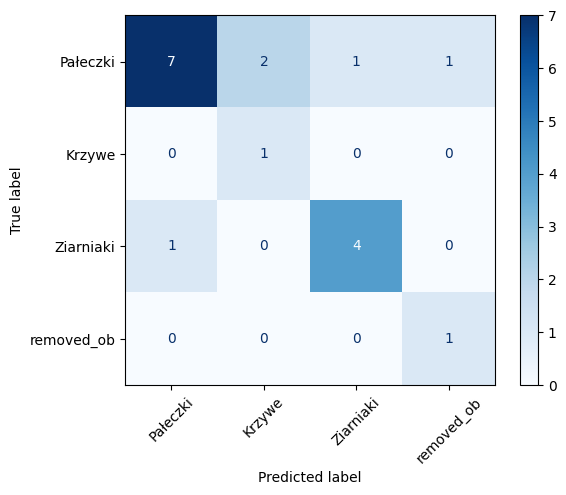

In [77]:
conf_matrix(real_df=real_df,predicted_df=predicted_df)

In [78]:
real_df[['nr.','powierzchniamm','dlugoscmm','szerokoscmm','Pw','R','D/S']]

,nr.,powierzchniamm,dlugoscmm,szerokoscmm,Pw,R,D/S
0,1,1.574944,1.956695,0.997723,1.738217,1.103669,1.961161
1,2,1.230425,1.725498,0.816478,1.265505,1.028510,2.113342
2,3,0.872483,1.377066,0.664396,0.820011,0.939859,2.072660
3,4,1.901566,3.056456,1.008946,2.864935,1.506619,3.029355
4,5,0.523490,0.934791,0.700692,0.549442,1.049575,1.334098
5,6,0.402685,1.022251,0.424467,0.395175,0.981351,2.408319
6,7,0.223714,0.577337,0.391339,0.193008,0.862747,1.475287
7,8,0.174497,0.524178,0.284741,0.131823,0.755449,1.840894
8,9,0.420582,0.808161,0.618761,0.417743,0.993250,1.306094
9,10,0.501119,1.237523,0.408239,0.469373,0.936651,3.031368


In [79]:
predicted_df[['nr.','powierzchniamm','dlugoscmm','szerokoscmm','Pw','R','D/S']]

,nr.,powierzchniamm,dlugoscmm,szerokoscmm,Pw,R,D/S
0,1,1.579418,2.046462,0.957423,1.762247,1.115757,2.137470
1,2,1.194631,1.724157,0.939597,1.430202,1.197191,1.834995
2,3,0.796421,1.342282,0.805369,0.941579,1.182264,1.666667
3,4,1.843400,3.020134,1.060593,2.961288,1.606427,2.847591
4,5,0.474273,0.872483,0.695383,0.502745,1.060034,1.254679
5,6,0.366890,1.003554,0.461100,0.417027,1.136653,2.176435
6,7,0.232662,0.536913,0.512588,0.218724,0.940094,1.047456
7,8,0.174497,0.536913,0.402685,0.181343,1.039236,1.333333
8,9,0.348993,0.744076,0.565344,0.351942,1.008449,1.316148
9,10,0.465324,1.177426,0.517705,0.551935,1.186130,2.274320


<Axes: >

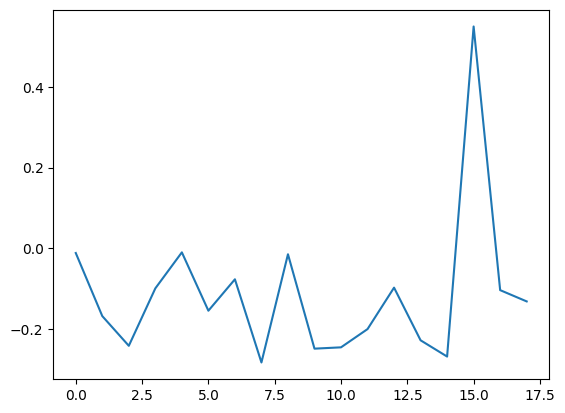

In [80]:
(real_df['R']-predicted_df['R']).plot()

<Axes: >

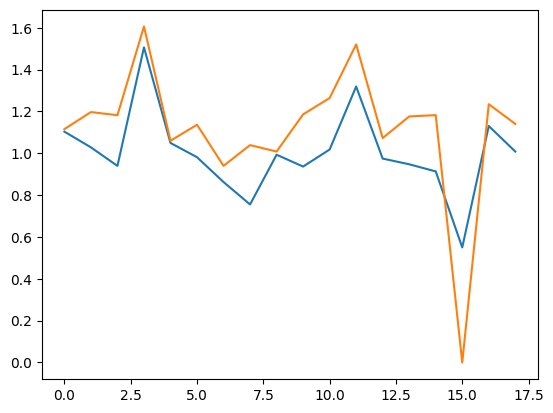

In [81]:
real_df['R'].plot()
(predicted_df['R']).plot()

<Axes: >

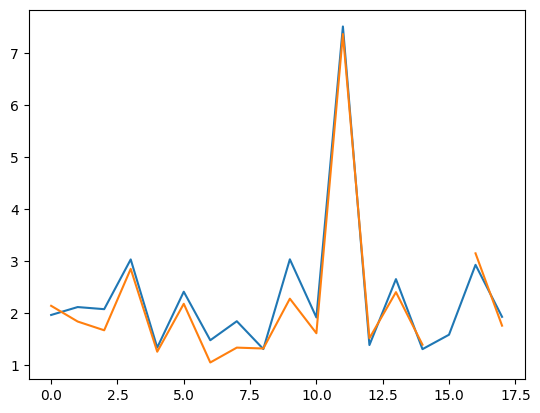

In [82]:
real_df['D/S'].plot()
predicted_df['D/S'].plot()

<Axes: >

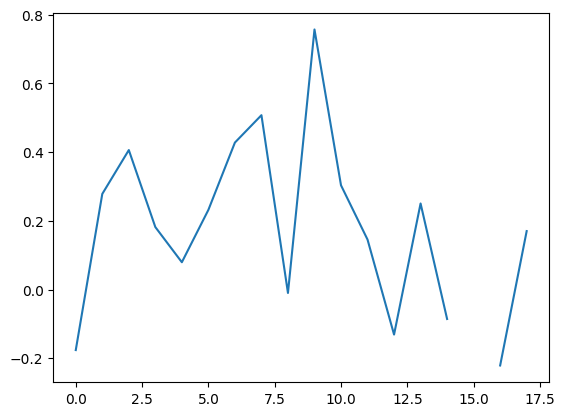

In [83]:
(real_df['D/S']-predicted_df['D/S']).plot()

<Axes: >

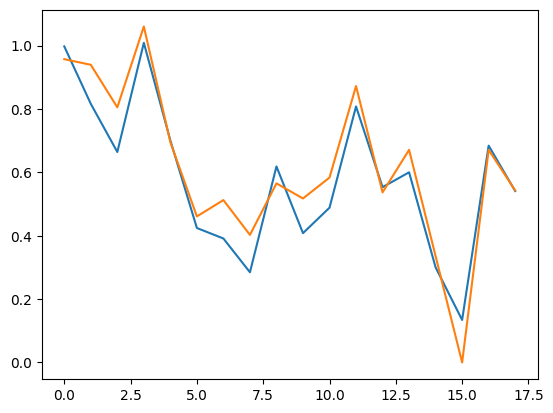

In [84]:
real_df['szerokoscmm'].plot()
(predicted_df['szerokoscmm']).plot()

<Axes: >

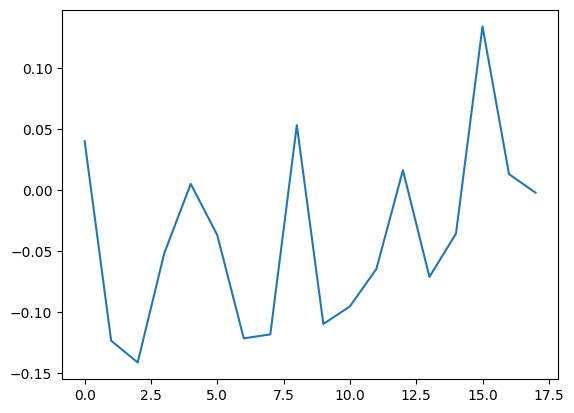

In [85]:
(real_df['szerokoscmm']-predicted_df['szerokoscmm']).plot()

<Axes: >

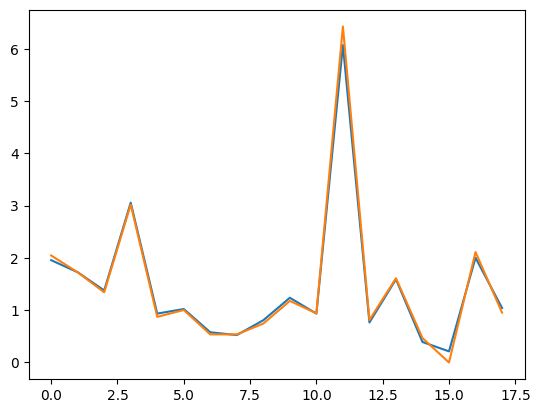

In [86]:
real_df['dlugoscmm'].plot()
(predicted_df['dlugoscmm']).plot()

<Axes: >

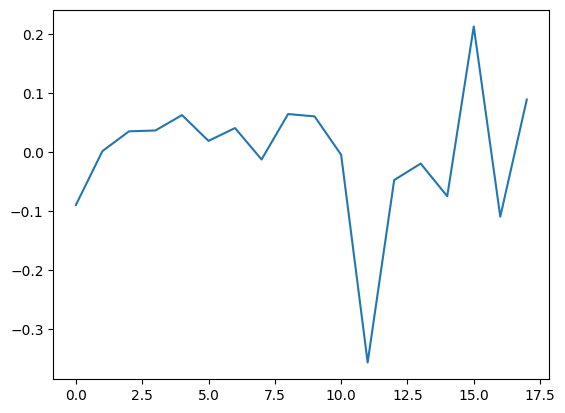

In [87]:
(real_df['dlugoscmm']-predicted_df['dlugoscmm']).plot()

<Axes: >

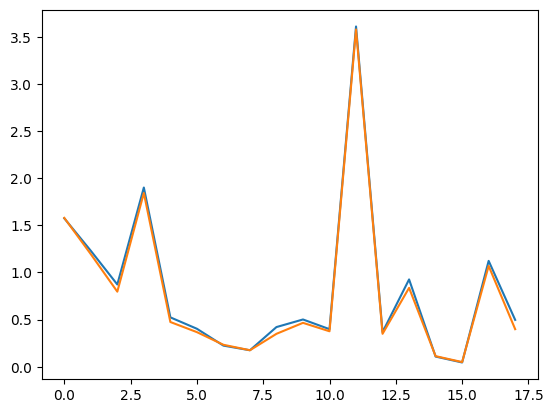

In [88]:
real_df['powierzchniamm'].plot()
(predicted_df['powierzchniamm']).plot()

<Axes: >

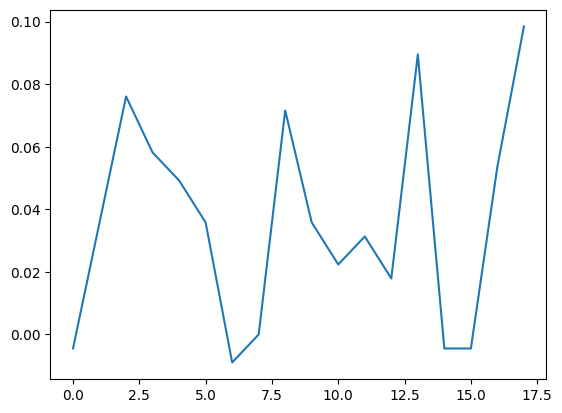

In [89]:
(real_df['powierzchniamm']-predicted_df['powierzchniamm']).plot()

In [90]:
real_df['powierzchniamm']-predicted_df['powierzchniamm']

0    -0.004474
1     0.035794
2     0.076063
3     0.058166
4     0.049217
5     0.035794
6    -0.008949
7     0.000000
8     0.071588
9     0.035794
10    0.022371
11    0.031320
12    0.017897
13    0.089485
14   -0.004474
15   -0.004474
16    0.053691
17    0.098434
Name: powierzchniamm, dtype: float64

In [91]:
real_df['dlugoscmm']-predicted_df['dlugoscmm']

0    -0.089767
1     0.001342
2     0.034784
3     0.036321
4     0.062308
5     0.018697
6     0.040425
7    -0.012735
8     0.064084
9     0.060097
10   -0.004806
11   -0.356202
12   -0.047574
13   -0.019695
14   -0.075000
15    0.212233
16   -0.109547
17    0.088665
Name: dlugoscmm, dtype: float64

In [92]:
real_df['szerokoscmm']-predicted_df['szerokoscmm']

0     0.040300
1    -0.123119
2    -0.140973
3    -0.051647
4     0.005308
5    -0.036633
6    -0.121249
7    -0.117944
8     0.053418
9    -0.109466
10   -0.095074
11   -0.064323
12    0.016524
13   -0.070854
14   -0.035427
15    0.134228
16    0.013291
17   -0.001908
Name: szerokoscmm, dtype: float64

In [93]:
df_errors = pd.DataFrame()
df_errors['error_dlugoscmm'] = real_df['dlugoscmm']-predicted_df['dlugoscmm']
df_errors['error_szerokoscmm'] = real_df['szerokoscmm']-predicted_df['szerokoscmm']
df_errors['error_powierzchniamm'] = real_df['powierzchniamm']-predicted_df['powierzchniamm']
df_errors['error_R'] = real_df['R']-predicted_df['R']
df_errors['error_D/S'] = real_df['D/S']-predicted_df['D/S']
df_errors.corr()

,error_dlugoscmm,error_szerokoscmm,error_powierzchniamm,error_R,error_D/S
error_dlugoscmm,1.000000,0.221810,0.108903,0.482043,0.350118
error_szerokoscmm,0.221810,1.000000,-0.067120,0.785245,-0.826691
error_powierzchniamm,0.108903,-0.067120,1.000000,-0.234134,0.022517
error_R,0.482043,0.785245,-0.234134,1.000000,-0.550078
error_D/S,0.350118,-0.826691,0.022517,-0.550078,1.000000


In [94]:
for i in range(1,11):
    try:
        process_one_image(IMAGE_PATH=f'images_y/a{i}.jpg',CSV_PATH_CORRECT=f'agata_1_y_real_correct_index/raport_a{i}.csv',CSV_PATH_PREDICTED=f'no_model_agata_4/a{i}_raport_no_model.csv',OUTPUT_PATH=f'no_model_agata_4/a{i}_elipses_compare.jpg')
    except:
        continue

Image saved to no_model_agata_4/a1_elipses_compare.jpg
Image saved to no_model_agata_4/a3_elipses_compare.jpg
Image saved to no_model_agata_4/a4_elipses_compare.jpg
Image saved to no_model_agata_4/a5_elipses_compare.jpg
Image saved to no_model_agata_4/a6_elipses_compare.jpg
Image saved to no_model_agata_4/a7_elipses_compare.jpg
Image saved to no_model_agata_4/a8_elipses_compare.jpg
Image saved to no_model_agata_4/a9_elipses_compare.jpg
Image saved to no_model_agata_4/a10_elipses_compare.jpg
